In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path

In [21]:
#import os

# Répertoire principal contenant les sous-dossiers par classe
#data_dir = "../wikiart/versions/1"

# Dictionnaire pour stocker {classe: nombre de fichiers}
#class_counts = {}

# Parcours des sous-dossiers
#for class_name in os.listdir(data_dir):
#    class_path = os.path.join(data_dir, class_name)
#    if os.path.isdir(class_path):
#        file_count = len([
#            f for f in os.listdir(class_path)
#            if os.path.isfile(os.path.join(class_path, f))
#        ])
#        class_counts[class_name] = file_count

# Tri par nombre croissant de fichiers
#sorted_counts = sorted(class_counts.items(), key=lambda x: x[1])

# Affichage
#for class_name, count in sorted_counts:
#    print(f"{class_name} : {count} fichiers")

In [28]:
data_dir = pathlib.Path("../wikiart/versions/1")

In [24]:
classes = ['Minimalism', 'Ukiyo_e', 'Pop_Art']

In [25]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


81444


In [26]:
batch_size = 32
img_height = 180
img_width = 180

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=classes,   
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3987 files belonging to 3 classes.
Using 3190 files for training.


2025-06-27 14:20:15.136890: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=classes,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3987 files belonging to 3 classes.
Using 797 files for validation.


In [32]:
class_names = train_ds.class_names
print("Classes utilisées :", class_names)

Classes utilisées : ['Minimalism', 'Ukiyo_e', 'Pop_Art']


2025-06-27 14:23:34.642944: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


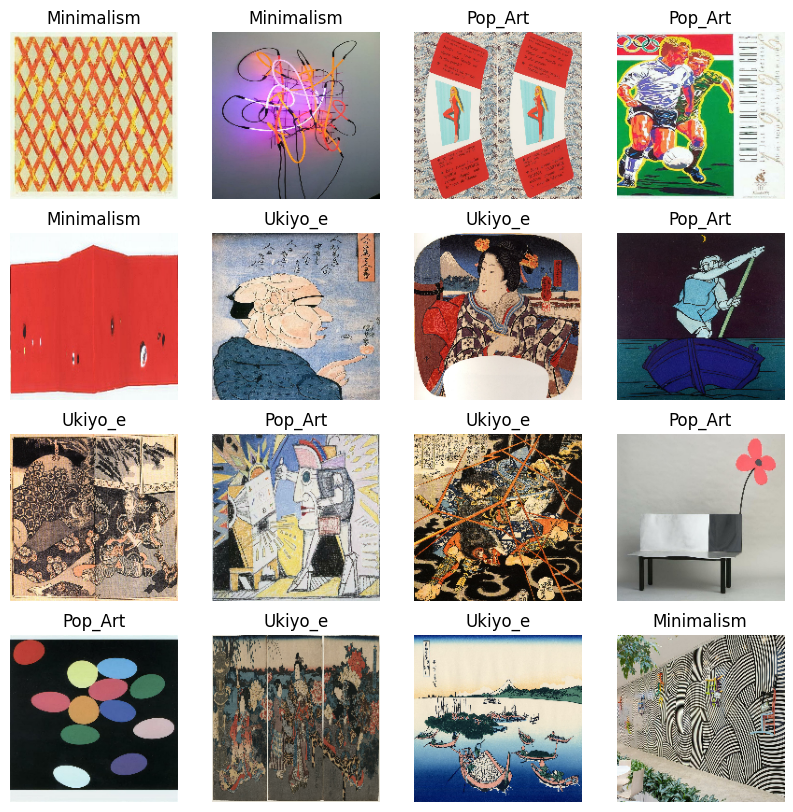

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


/home/carriqui.alexandre/.pyenv/versions/art_and_facts/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 673ms/step - accuracy: 0.4898 - loss: 1.2556 - val_accuracy: 0.6725 - val_loss: 0.7321
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 616ms/step - accuracy: 0.7194 - loss: 0.6574 - val_accuracy: 0.7252 - val_loss: 0.6369
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 621ms/step - accuracy: 0.7755 - loss: 0.5550 - val_accuracy: 0.6876 - val_loss: 0.7440
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 612ms/step - accuracy: 0.8034 - loss: 0.4770 - val_accuracy: 0.7277 - val_loss: 0.6418
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 620ms/step - accuracy: 0.8488 - loss: 0.3891 - val_accuracy: 0.7666 - val_loss: 0.5985
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 619ms/step - accuracy: 0.8783 - loss: 0.3036 - val_accuracy: 0.7516 - val_loss: 0.5820
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 629ms/step - accuracy: 0.9073 - loss: 0.2526 - val_accuracy: 0.7729 - val_loss: 0.5847
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 617ms/step - accuracy: 0.9021 - loss: 0

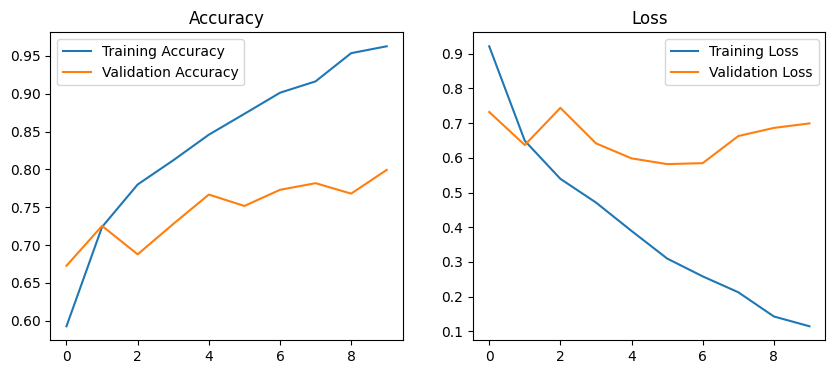

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()